## Overview plot updated

Specify folder here

In [70]:
folder_name_maybritt = "full2"
folder_name_benchmarks = "full"

In [71]:
method_mapping = {
    'maybritt_3step_dense-conv_v3': 'EnScale-old',
    'maybritt_3step_dense-conv_temporal_v2': 'EnScale-old-t',
    "maybritt_nicolai_zeros-constant_dec-1e-3_v2": "EnScale-no-label",
    "maybritt_nicolai_zeros-constant_dec-1e-3_onehot": "EnScale",
    "maybritt_nicolai_zeros-constant_dec-1e-3_temporal_v2": "EnScale-t-no-label",
    "maybritt_nicolai_zeros-constant_dec-1e-3_onehot_temporal": "EnScale-t",
    "nn_det_per_variable": "NN-det",
    "gan": "GAN",
    "analogues": "Analogues",
    "idr": "EasyUQ",
    "corrdiff": "CorrDiff-s",
    "corrdiff_mini": "CorrDiff-mini",
    "corrdiff_fixed-seeds": "CorrDiff"
}
#method_order = ["EnScale", "EnScale-t", "EnScale-new", "EnScale-new-onehot", "EnScale-new-t", "EnScale-new-onehot-t", "CorrDiff"]
# method_order = ["NN-det",  "EasyUQ", "Analogues", "GAN", "CorrDiff", "CorrDiff-s", "EnScale", "EnScale-t"]
method_order = ["NN-det",  "EasyUQ", "Analogues", "GAN", "CorrDiff", "EnScale", "EnScale-t"]
base_method = "EnScale"
version_name = "vnewlayers2"

Options to generate interesting plots

    method_order = ["EnScale", "EnScale-new-onehot", "CorrDiff"]
    base_method = "EnScale-new-onehot"

    method_order = ["EnScale-new", "EnScale-new-onehot", "EnScale-new-t", "EnScale-new-onehot-t"]
    base_method = "EnScale-new-onehot"

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [73]:

# ------------------------
# Helper Functions
# ------------------------

def standardize_methods(df, method_mapping):
    df = df.copy()
    df['method'] = df['method'].replace(method_mapping)
    return df

def scale_and_composite(df, metric_groups, method_order, base_method="EnScale"):
    df = df.copy()
    for group in metric_groups.values():
        for metric in group:
            if base_method is not None:
                df[metric] = df[metric] / df[df['method'] == base_method][metric].values[0]
            else:
                pass

    for name, group in metric_groups.items():
        df[name] = df[group].mean(axis=1)

    df = df.set_index('method').loc[method_order]
    return df

def plot_heatmap(ax, df, metrics, title, annotate=True, font_size=14):
    sns.heatmap(df[metrics], annot=annotate, annot_kws={"size": font_size},
                cmap="coolwarm", center=1, linewidths=0.5, vmin=0.5, vmax=2,
                ax=ax, cbar=False)
    ax.set_title(title)
    return ax

# ------------------------
# Layout 1: 2x2 Overview
# ------------------------

def plot_2x2(df_per_var, metric_groups, method_mapping, method_order, base_method="EnScale"):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    plt.rcParams.update({'font.size': 14})
    variables = ['tas', 'pr', 'sfcWind', 'rsds']
    axes = axes.flatten()

    for ax, var in zip(axes, variables):
        df = standardize_methods(df_per_var[var], method_mapping)
        df_scaled = scale_and_composite(df, metric_groups, method_order, base_method=base_method)
        plot_heatmap(ax, df_scaled, list(metric_groups.keys()), var)

        # Format axes
        if var in ['tas', 'pr']:
            ax.set_xticks([])
        if var in ['pr', 'rsds']:
            ax.set_ylabel('')
            ax.set_yticks([])
        if var in ['sfcWind', 'rsds']:
            ax.set_xlabel('Metrics')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        if var in ['tas', 'sfcWind']:
            ax.set_ylabel('Methods')
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout(rect=[0.05, 0.05, 1, 1])

# ------------------------
# Layout 2: GridSpec with Multivariate
# ------------------------

def plot_combined_grid(df_per_var, df_multivariate_plot, metric_groups, multivariate_metrics, method_mapping, method_order, base_method="EnScale", version="v1"):
    fig = plt.figure(figsize=(18, len(method_order) * 0.8 + 2))
    gs = GridSpec(2, 3, width_ratios=[1, 1, 0.4], wspace=0.3, hspace=0.3)

    variables = ['tas', 'pr', 'sfcWind', 'rsds']
    axes = [fig.add_subplot(gs[i // 2, i % 2]) for i in range(4)]
    ax_mv = fig.add_subplot(gs[1, 2])

    for ax, var in zip(axes, variables):
        df = standardize_methods(df_per_var[var], method_mapping)
        df_scaled = scale_and_composite(df, metric_groups, method_order, base_method=base_method)
        plot_heatmap(ax, df_scaled, list(metric_groups.keys()), var)

        # Formatting
        ax.set_xticklabels([] if var in ['tas', 'pr'] else ax.get_xticklabels(), rotation=45, ha='right')
        if var in ['tas', 'pr']:
            ax.set_xticks([])
        if var in ['pr', 'rsds']:
            ax.set_ylabel('')
            ax.set_yticks([])
        elif var in ['tas', 'sfcWind']:
            ax.set_ylabel('Methods')
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        if var in ['sfcWind', 'rsds']:
            ax.set_xlabel('Metrics')

    # Multivariate subplot
    plot_heatmap(ax_mv, df_multivariate_plot, multivariate_metrics, "Multivariate", font_size=14)
    ax_mv.set_xticklabels(ax_mv.get_xticklabels(), rotation=45, ha='right')
    ax_mv.set_yticks([])
    ax_mv.set_yticklabels([])
    ax_mv.set_xlabel('Metrics')

    plt.tight_layout(rect=[0.02, 0.02, 1, 1])
    plt.savefig(f"figures/overview_heatmap_combined_{version}.png", bbox_inches='tight', dpi=300)
    plt.show()
    
    

def process_multivariate_metrics(
    df_raw: pd.DataFrame,
    method_mapping: dict,
    method_order: list,
    metric_groups: dict,
    base_method: str = "EnScale",
    drop_indices: list = [1, 6, 8],  # if you want to optionally skip dropping, allow None
    scaling_factor: float = 128 * 128 / 1000,
    return_pivot: bool = False
) -> pd.DataFrame:
    """
    Processes raw multivariate evaluation results and returns a normalized DataFrame ready for plotting.

    Parameters:
    - df_raw: Raw input DataFrame with multivariate evaluation results.
    - method_mapping: Dict mapping raw method names to display names.
    - method_order: List of method display names in desired order.
    - metric_groups: Dict of composite metrics, e.g. {"Calibration": [...], "Correlations": [...]}
    - base_method: Method to normalize against (default is "EnScale").
    - drop_indices: List of row indices to drop after pivot (default [1,6,8]).
    - scaling_factor: Factor to rescale spatial values (default assumes 1000 locations originally).

    Returns:
    - Processed and normalized DataFrame indexed by method names.
    """

    df = df_raw.copy()
    df['var_combined'] = df['var1'] + '-' + df['var2']

    # Rescale MCB and RH scores
    for col in ['mcb_loc_average', 'rh_mean_loc_average', 'rh_var_loc_average']:
        df[col] *= scaling_factor

    # Remove broken metric values for specific method
    for col in ['mcb_loc_average', 'rh_mean_loc_average', 'rh_var_loc_average']:
        df.loc[df["method"] == "nn_det_per_variable", col] = np.nan

    # Pivot the table
    df_pivot = df.pivot_table(index='method', columns='var_combined', values=['PW corrs pixelwise', 'mcb_loc_average'])
    df_pivot.reset_index(inplace=True)

    # Drop rows if requested
    if drop_indices:
        df_pivot.drop(index=drop_indices, inplace=True)
        df_pivot.reset_index(drop=True, inplace=True)

    # Rename methods
    df_pivot['method'] = df_pivot['method'].replace(method_mapping)
    df_pivot = df_pivot.set_index('method')

    # Rename columns to flat structure
    df_pivot.rename(columns={col: "Correlations" if col == "PW corrs pixelwise" else "Miscalibration"
                             for col in df_pivot.columns.levels[0] if isinstance(col, str)}, inplace=True)

    # Flatten multi-index
    df_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_pivot.columns]

    # Normalize each metric to the baseline
    for metric in df_pivot.columns:
        if base_method is not None:
            if base_method in df_pivot.index and not df_pivot[metric].isnull().all():
                df_pivot[metric] /= df_pivot.loc[base_method, metric]   

    # Aggregate metrics into groups
    for group_name, group_metrics in metric_groups.items():
        if group_metrics:  # only compute mean if metric list is non-empty
            cols = [col for col in df_pivot.columns if any(m in col for m in group_metrics)]
            df_pivot[group_name] = df_pivot[cols].mean(axis=1)

    # Reorder and clean output
    df_out = df_pivot.loc[method_order, list(metric_groups.keys())]
    df_out.index.name = None
    if return_pivot:
        return df_out, df_pivot
    return df_out

In [74]:
df_per_var = {}
for var in ['tas', 'pr', 'sfcWind', 'rsds']:
    if folder_name_maybritt is not None:
        df = pd.read_csv(f"output_evals/maybritt/interpolation/{folder_name_maybritt}/{var}/concatenated_results_2030-2039_multiple-methods_2378111217.csv")
    if folder_name_benchmarks is not None:
        df_bench = pd.read_csv(f"output_evals/benchmarks/interpolation/{folder_name_benchmarks}/{var}/concatenated_results_2030-2039_maybritt_3step_dense-conv_v3_2378111217.csv")
    
    if folder_name_maybritt is not None and folder_name_benchmarks is not None:
        df = pd.concat([df, df_bench])
    elif folder_name_benchmarks is not None:
        df = df_bench
    df_per_var[var] = df

In [75]:
if folder_name_maybritt is not None:
    df1 = pd.read_csv(f"output_evals/maybritt/interpolation/{folder_name_maybritt}/multivariate_concatenated_results_2030-2039_multiple-methods_1315.csv")
if folder_name_benchmarks is not None:
    df_bench1 = pd.read_csv(f"output_evals/benchmarks/interpolation/{folder_name_benchmarks}/multivariate_concatenated_results_2030-2039_maybritt_3step_dense-conv_v3_1315.csv")

if folder_name_maybritt is not None and folder_name_benchmarks is not None:
    df_multi = pd.concat([df1, df_bench1])
elif folder_name_benchmarks is not None:
    df_multi = df_bench1

/tmp/ipykernel_1716427/2426392708.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 1, 1])


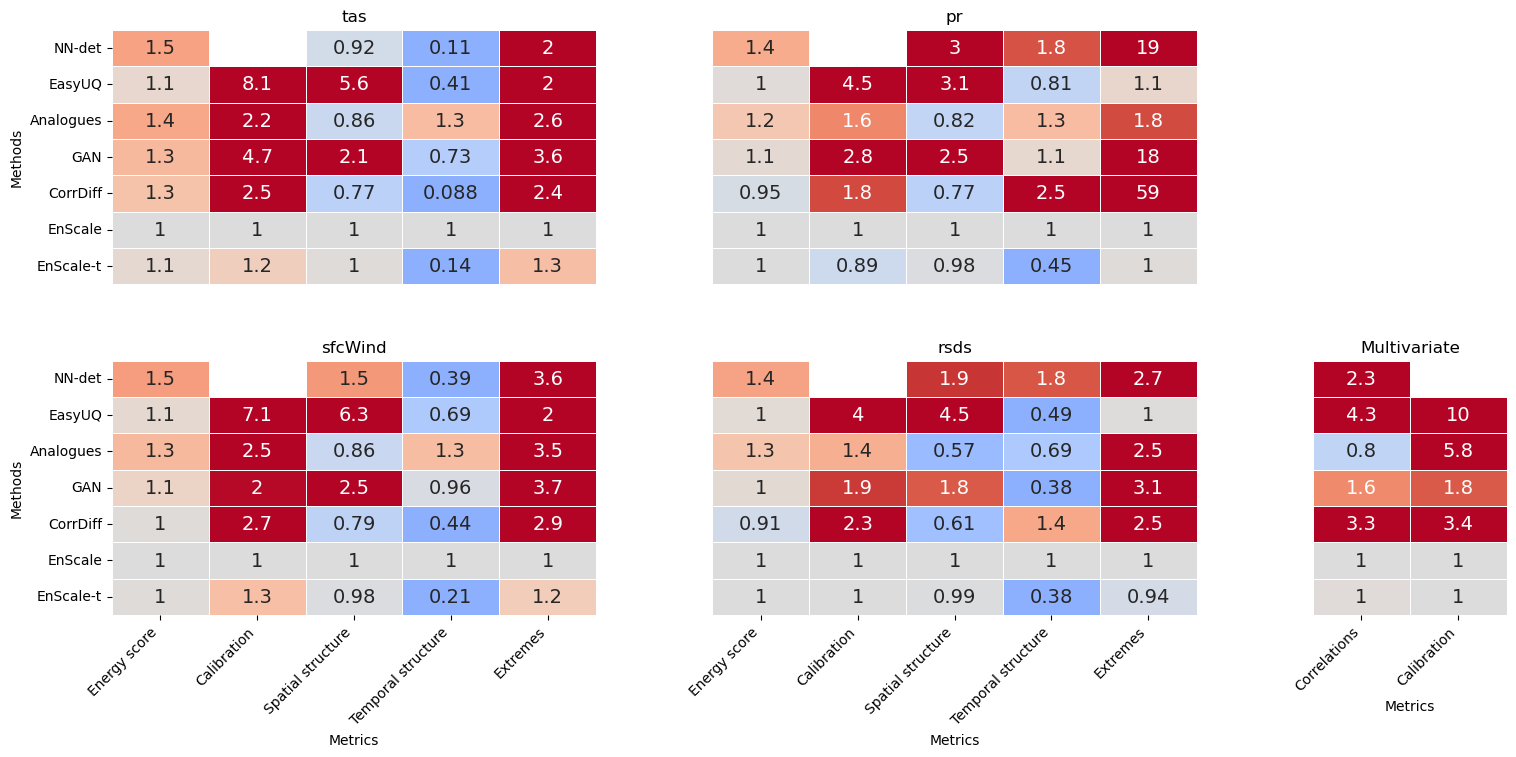

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec

# ------------------------
# Configuration
# ------------------------

# Original metric list (from your first layout)
metrics_primary = {
    "Energy score": ["mean*ES_pool-None_kernel-1"],
    "Calibration": ["sp_mean_mcb", "sp_max_mcb", "loc_avg_mcb"],
    "Spatial structure": ["mean*CRPS_pool-max_kernel-10", "mean*LSD-daily", "mean*LSD-avg"],
    "Temporal structure": ["ACF_lag1_abs_error_pool-None_kernel-1"],
    "Extremes": ["loc_avg_mcb_last_bin", "loc_avg_mcb_first_bin",
                 "q-error_months-6-7-8_q-0.95", "q-error_months-12-1-2_q-0.05"]
}

# For simple 2x2 overview:
#plot_2x2(df_per_var, metrics_primary, method_mapping, method_order)

# For combined GridSpec view with multivariate:
df_multivariate_plot = process_multivariate_metrics(
    df_raw=df_multi,
    method_mapping=method_mapping,
    method_order=method_order,
    metric_groups={"Correlations": ["Correlations_pr-sfcWind", "Correlations_sfcWind-rsds", "Correlations_tas-pr"],
                   "Calibration": ["Miscalibration_pr-sfcWind", "Miscalibration_sfcWind-rsds", "Miscalibration_tas-pr"]},  # or your composite structure
    drop_indices=[],
    base_method=base_method,
)

plot_combined_grid(df_per_var, df_multivariate_plot, metrics_primary, ["Correlations", "Calibration"],
                   method_mapping, method_order, base_method=base_method, version=version_name)


# Label

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

In [78]:
df_per_var = {}
for var in ['tas', 'pr', 'sfcWind', 'rsds']:
    if folder_name_maybritt is not None:
        df = pd.read_csv(f"output_evals/maybritt/interpolation/{folder_name_maybritt}/{var}/concatenated_results_2030-2039_multiple-methods_2378111217.csv")
    if folder_name_benchmarks is not None:
        df_bench = pd.read_csv(f"output_evals/benchmarks/interpolation/{folder_name_benchmarks}/{var}/concatenated_results_2030-2039_maybritt_3step_dense-conv_v3_2378111217.csv")
    
    if folder_name_maybritt is not None and folder_name_benchmarks is not None:
        df = pd.concat([df, df_bench])
    elif folder_name_benchmarks is not None:
        df = df_bench
    df_per_var[var] = df
    
if folder_name_maybritt is not None:
    df1 = pd.read_csv(f"output_evals/maybritt/interpolation/{folder_name_maybritt}/multivariate_concatenated_results_2030-2039_multiple-methods_1315.csv")
if folder_name_benchmarks is not None:
    df_bench1 = pd.read_csv(f"output_evals/benchmarks/interpolation/{folder_name_benchmarks}/multivariate_concatenated_results_2030-2039_maybritt_3step_dense-conv_v3_1315.csv")

if folder_name_maybritt is not None and folder_name_benchmarks is not None:
    df_multi = pd.concat([df1, df_bench1])
elif folder_name_benchmarks is not None:
    df_multi = df_bench1

['EnScale', 'EnScale-no-label', 'EnScale-t', 'EnScale-t-no-label']


/tmp/ipykernel_1716427/2426392708.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 1, 1])


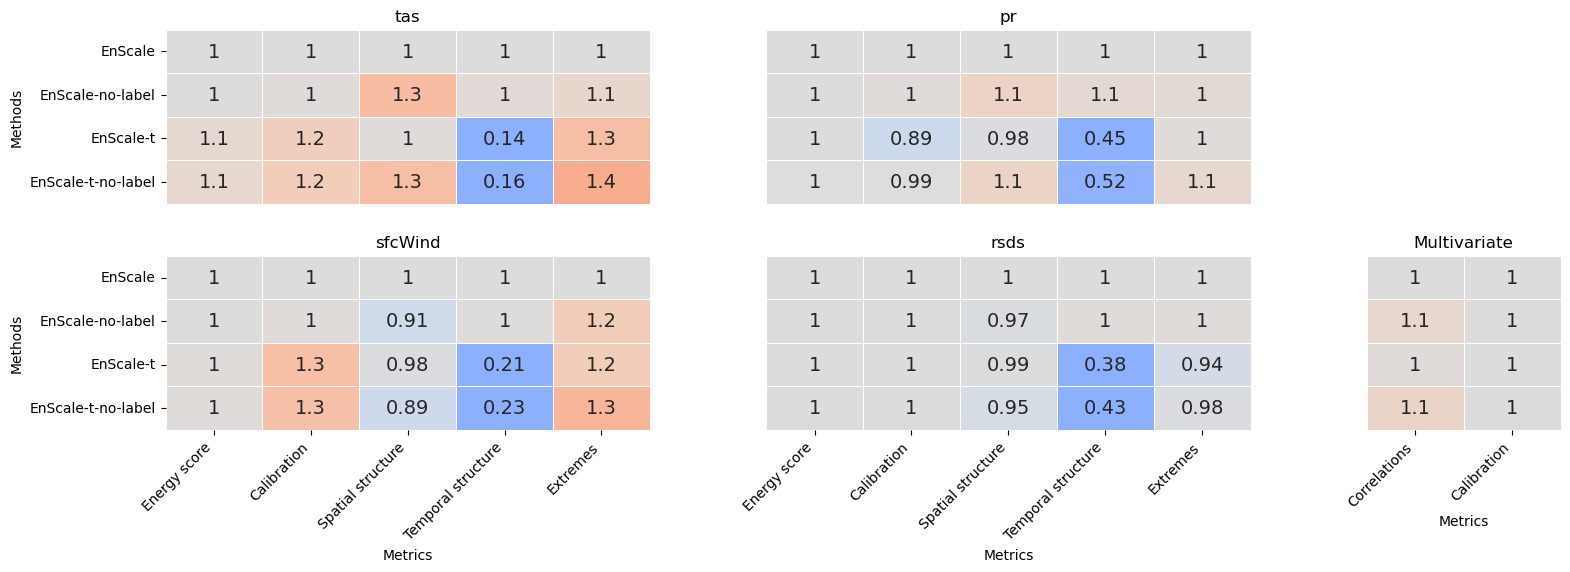

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec

# ------------------------
# Configuration
# ------------------------

method_order_label = ["EnScale", "EnScale-no-label", "EnScale-t", "EnScale-t-no-label"]
#method_order_label = method_order + ["EnScale-no-label", "EnScale-t-no-label"]
print(method_order_label)
# Original metric list (from your first layout)
metrics_primary = {
    "Energy score": ["mean*ES_pool-None_kernel-1"],
    "Calibration": ["sp_mean_mcb", "sp_max_mcb", "loc_avg_mcb"],
    "Spatial structure": ["mean*CRPS_pool-max_kernel-10", "mean*LSD-daily", "mean*LSD-avg"],
    "Temporal structure": ["ACF_lag1_abs_error_pool-None_kernel-1"],
    "Extremes": ["loc_avg_mcb_last_bin", "loc_avg_mcb_first_bin",
                 "q-error_months-6-7-8_q-0.95", "q-error_months-12-1-2_q-0.05"]
}

df_multivariate_plot = process_multivariate_metrics(
    df_raw=df_multi,
    method_mapping=method_mapping,
    method_order=method_order_label,
    metric_groups={"Correlations": ["Correlations_pr-sfcWind", "Correlations_sfcWind-rsds", "Correlations_tas-pr"],
                   "Calibration": ["Miscalibration_pr-sfcWind", "Miscalibration_sfcWind-rsds", "Miscalibration_tas-pr"]},  # or your composite structure
    drop_indices=[],
    base_method=base_method,
)
# For combined GridSpec view with multivariate:
plot_combined_grid(df_per_var, df_multivariate_plot, 
                   metrics_primary, 
                   multivariate_metrics=["Correlations", "Calibration"],
                   method_mapping=method_mapping, 
                   method_order=method_order_label,
                   base_method=base_method,
                   version=version_name + "_label-vs-not")


# Check extrapolation

### Just extrapolation period

In [80]:
import pandas as pd
import numpy as np

In [81]:
df_per_var = {}
for var in ['tas', 'pr', 'sfcWind', 'rsds']:
    if folder_name_maybritt is not None:
        df = pd.read_csv(f"output_evals/maybritt/extrapolation/{folder_name_maybritt}/{var}/concatenated_results_2090-2099_multiple-methods_2378111217.csv")
    if folder_name_benchmarks is not None:
        df_bench = pd.read_csv(f"output_evals/benchmarks/extrapolation/{folder_name_benchmarks}/{var}/concatenated_results_2090-2099_maybritt_3step_dense-conv_v3_2378111217.csv")
    
    if folder_name_maybritt is not None and folder_name_benchmarks is not None:
        df = pd.concat([df, df_bench])
    elif folder_name_benchmarks is not None:
        df = df_bench
    df_per_var[var] = df

In [82]:
if folder_name_maybritt is not None:
    df1 = pd.read_csv(f"output_evals/maybritt/extrapolation/{folder_name_maybritt}/multivariate_concatenated_results_2090-2099_multiple-methods_1315.csv")
if folder_name_benchmarks is not None:
    df_bench1 = pd.read_csv(f"output_evals/benchmarks/extrapolation/{folder_name_benchmarks}/multivariate_concatenated_results_2090-2099_maybritt_3step_dense-conv_v3_1315.csv")

if folder_name_maybritt is not None and folder_name_benchmarks is not None:
    df_multi = pd.concat([df1, df_bench1])
elif folder_name_benchmarks is not None:
    df_multi = df_bench1

In [83]:
df_multi

,method,PW corrs pixelwise,PW corrs max-pool 10x10,PW corrs avg-pool 10x10,var1,var2,mcb_loc_average,rh_mean_loc_average,rh_var_loc_average
0,maybritt_nicolai_zeros-constant_dec-1e-3_onehot,0.033217,0.081105,0.032452,tas,pr,NaN,NaN,NaN
1,maybritt_nicolai_zeros-constant_dec-1e-3_oneho...,0.034648,0.084362,0.035352,tas,pr,NaN,NaN,NaN
2,maybritt_nicolai_zeros-constant_dec-1e-3_oneho...,0.040505,0.092835,0.043574,tas,pr,NaN,NaN,NaN
3,maybritt_nicolai_zeros-constant_dec-1e-3_oneho...,0.038222,0.089046,0.040713,tas,pr,NaN,NaN,NaN
4,maybritt_nicolai_zeros-constant_dec-1e-3_tempo...,0.038143,0.078113,0.039554,tas,pr,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
49,gan,NaN,NaN,NaN,sfcWind,rsds,0.005488,0.332604,0.533839
50,idr,NaN,NaN,NaN,sfcWind,rsds,0.047157,0.333049,0.870231
51,maybritt_3step_dense-conv_v3,NaN,NaN,NaN,sfcWind,rsds,0.003433,0.334359,0.498554
52,maybritt_3step_dense-conv_v3_shuffled,NaN,NaN,NaN,sfcWind,rsds,0.004159,0.334193,0.514079


/tmp/ipykernel_1716427/2426392708.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 1, 1])


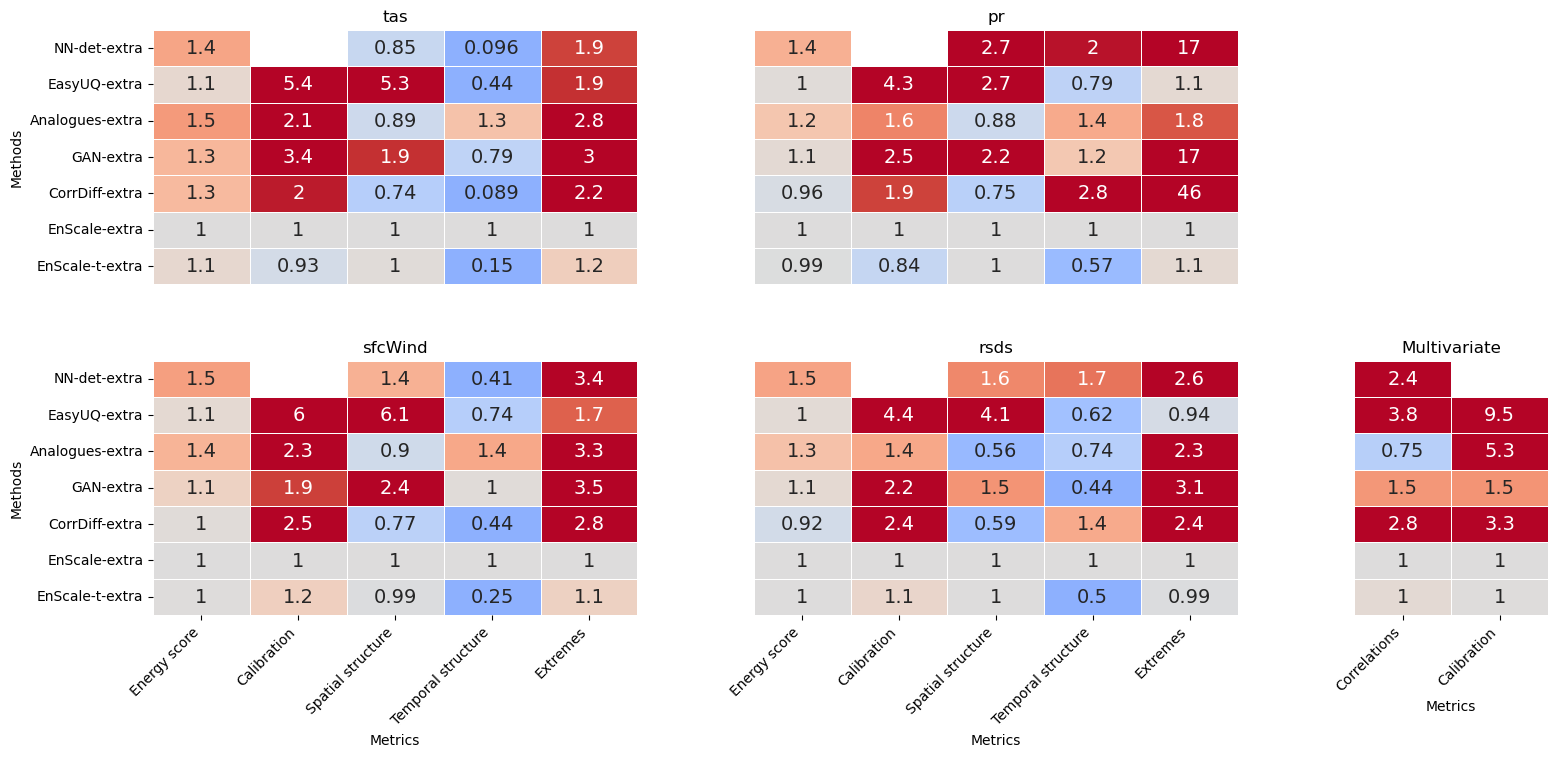

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec

# ------------------------
# Configuration
# ------------------------

# Original metric list (from your first layout)
metrics_primary = {
    "Energy score": ["mean*ES_pool-None_kernel-1"],
    "Calibration": ["sp_mean_mcb", "sp_max_mcb", "loc_avg_mcb"],
    "Spatial structure": ["mean*CRPS_pool-max_kernel-10", "mean*LSD-daily", "mean*LSD-avg"],
    "Temporal structure": ["ACF_lag1_abs_error_pool-None_kernel-1"],
    "Extremes": ["loc_avg_mcb_last_bin", "loc_avg_mcb_first_bin",
                 "q-error_months-6-7-8_q-0.95", "q-error_months-12-1-2_q-0.05"]
}

# For simple 2x2 overview:


method_mapping_extra = {k: v + "-extra" for k, v in method_mapping.items()}
base_method_extra = base_method + "-extra"
method_order_extra = [m + "-extra" for m in method_order]
# For combined GridSpec view with multivariate:

#plot_2x2(df_per_var, metrics_primary, method_mapping_extra, method_order_extra, base_method=base_method_extra)

df_multivariate_plot = process_multivariate_metrics(
    df_raw=df_multi,
    method_mapping=method_mapping_extra,
    method_order=method_order_extra,
    metric_groups={"Correlations": ["Correlations_pr-sfcWind", "Correlations_sfcWind-rsds", "Correlations_tas-pr"],
                   "Calibration": ["Miscalibration_pr-sfcWind", "Miscalibration_sfcWind-rsds", "Miscalibration_tas-pr"]},  # or your composite structure
    drop_indices=[],
    base_method=base_method_extra,
)

plot_combined_grid(df_per_var, df_multivariate_plot, metrics_primary, ["Correlations", "Calibration"],
                   method_mapping_extra, method_order_extra, base_method=base_method_extra, version=version_name + "_extrapolation")


### Comparison inter vs extra

In [85]:
df_per_var = {}
for var in ['tas', 'pr', 'sfcWind', 'rsds']:
    if folder_name_maybritt is not None:
        df = pd.read_csv(f"output_evals/maybritt/extrapolation/{folder_name_maybritt}/{var}/concatenated_results_2090-2099_multiple-methods_2378111217.csv")
    if folder_name_benchmarks is not None:
        df_bench = pd.read_csv(f"output_evals/benchmarks/extrapolation/{folder_name_benchmarks}/{var}/concatenated_results_2090-2099_maybritt_3step_dense-conv_v3_2378111217.csv")
    
    if folder_name_maybritt is not None and folder_name_benchmarks is not None:
        df = pd.concat([df, df_bench])
    elif folder_name_benchmarks is not None:
        df = df_bench
    df["period"] = "extra"
    df_per_var[var] = df
    
for var in ['tas', 'pr', 'sfcWind', 'rsds']:
    if folder_name_maybritt is not None:
        df = pd.read_csv(f"output_evals/maybritt/interpolation/{folder_name_maybritt}/{var}/concatenated_results_2030-2039_multiple-methods_2378111217.csv")
    if folder_name_benchmarks is not None:
        df_bench = pd.read_csv(f"output_evals/benchmarks/interpolation/{folder_name_benchmarks}/{var}/concatenated_results_2030-2039_maybritt_3step_dense-conv_v3_2378111217.csv")

    if folder_name_maybritt is not None and folder_name_benchmarks is not None:
        df = pd.concat([df, df_bench])
    elif folder_name_benchmarks is not None:
        df = df_bench
    df["period"] = "inter"
    df_per_var[var] = pd.concat([df_per_var[var], df])

In [86]:
metrics_primary = {
    "Energy score": ["mean*ES_pool-None_kernel-1"],
    "Calibration": ["sp_mean_mcb", "sp_max_mcb", "loc_avg_mcb"],
    "Spatial structure": ["mean*CRPS_pool-max_kernel-10", "mean*LSD-daily", "mean*LSD-avg"],
    "Temporal structure": ["ACF_lag1_abs_error_pool-None_kernel-1"],
    "Extremes": ["loc_avg_mcb_last_bin", "loc_avg_mcb_first_bin",
                 "q-error_months-6-7-8_q-0.95", "q-error_months-12-1-2_q-0.05"]
}
# Build ratio DataFrame: (extra/inter) for each method and metric in metrics_primary

metrics = [m for group in metrics_primary.values() for m in group]
methods = []

df_ratio_per_var = {}

for var in ['tas', 'pr', 'sfcWind', 'rsds']:
    rows = []
    df_var = df_per_var[var]

    for method in df_var["method"].unique():
        df_inter = df_var[(df_var["method"] == method) & (df_var["period"] == "inter")]
        df_extra = df_var[(df_var["method"] == method) & (df_var["period"] == "extra")]
        if df_inter.empty or df_extra.empty:
            continue
        row = {}
        for metric in metrics:
            val_inter = df_inter.iloc[0][metric]
            val_extra = df_extra.iloc[0][metric]
            row[metric] = val_extra / val_inter if val_inter != 0 else np.nan
        row["method"] = method
        rows.append(row)

    df_ratio = pd.DataFrame(rows)#.set_index("method")
    df_ratio_per_var[var] = df_ratio

In [87]:
if folder_name_maybritt is not None:
    df1 = pd.read_csv(f"output_evals/maybritt/extrapolation/{folder_name_maybritt}/multivariate_concatenated_results_2090-2099_multiple-methods_1315.csv")
if folder_name_benchmarks is not None:
    df_bench1 = pd.read_csv(f"output_evals/benchmarks/extrapolation/{folder_name_benchmarks}/multivariate_concatenated_results_2090-2099_maybritt_3step_dense-conv_v3_1315.csv")

if folder_name_maybritt is not None and folder_name_benchmarks is not None:
    df_multi = pd.concat([df1, df_bench1])
elif folder_name_benchmarks is not None:
    df_multi = df_bench1
    
df_multivariate_plot, df_pivot_extra = process_multivariate_metrics(
    df_raw=df_multi,
    method_mapping=method_mapping,
    method_order=method_order,
    metric_groups={"Correlations": ["Correlations_pr-sfcWind", "Correlations_sfcWind-rsds", "Correlations_tas-pr"],
                   "Calibration": ["Miscalibration_pr-sfcWind", "Miscalibration_sfcWind-rsds", "Miscalibration_tas-pr"]},  # or your composite structure
    drop_indices=[],
    base_method=None,
    return_pivot=True
)
df_pivot_extra["period"] = "extra"


if folder_name_maybritt is not None:
    df1 = pd.read_csv(f"output_evals/maybritt/interpolation/{folder_name_maybritt}/multivariate_concatenated_results_2030-2039_multiple-methods_1315.csv")
if folder_name_benchmarks is not None:
    df_bench1 = pd.read_csv(f"output_evals/benchmarks/interpolation/{folder_name_benchmarks}/multivariate_concatenated_results_2030-2039_maybritt_3step_dense-conv_v3_1315.csv")

if folder_name_maybritt is not None and folder_name_benchmarks is not None:
    df_multi = pd.concat([df1, df_bench1])
elif folder_name_benchmarks is not None:
    df_multi = pd.concat([df_bench1])
    
df_multivariate_plot, df_pivot_inter = process_multivariate_metrics(
    df_raw=df_multi,
    method_mapping=method_mapping,
    method_order=method_order,
    metric_groups={"Correlations": ["Correlations_pr-sfcWind", "Correlations_sfcWind-rsds", "Correlations_tas-pr"],
                   "Calibration": ["Miscalibration_pr-sfcWind", "Miscalibration_sfcWind-rsds", "Miscalibration_tas-pr"]},  # or your composite structure
    drop_indices=[],
    base_method=None,
    return_pivot=True
)
df_pivot_inter["period"] = "inter"

df_multi_pivot = pd.concat([df_pivot_extra, df_pivot_inter])
df_multi_pivot.drop(columns=["Correlations", "Calibration"], inplace=True)
df_multi_pivot

metrics = df_multi_pivot.columns.tolist()
metrics.remove("period")
df_multi_pivot.reset_index(inplace=True)

rows = []
for method in df_multi_pivot["method"].unique():
    df_inter = df_multi_pivot[(df_multi_pivot["method"] == method) & (df_multi_pivot["period"] == "inter")]
    df_extra = df_multi_pivot[(df_multi_pivot["method"] == method) & (df_multi_pivot["period"] == "extra")]
    if df_inter.empty or df_extra.empty:
        continue
    row = {}
    for metric in metrics:
        val_inter = df_inter.iloc[0][metric]
        val_extra = df_extra.iloc[0][metric]
        row[metric] = val_extra / val_inter if val_inter != 0 else np.nan
    row["method"] = method
    rows.append(row)

df_ratio = pd.DataFrame(rows)#.set_index("method")
df_ratio

metric_groups = {"Correlations": ["Correlations_pr-sfcWind", "Correlations_sfcWind-rsds", "Correlations_tas-pr"],
                   "Calibration": ["Miscalibration_pr-sfcWind", "Miscalibration_sfcWind-rsds", "Miscalibration_tas-pr"]}
for group_name, group_metrics in metric_groups.items():
    if group_metrics:  # only compute mean if metric list is non-empty
        cols = [col for col in df_ratio.columns if any(m in col for m in group_metrics)]
        df_ratio[group_name] = df_ratio[cols].mean(axis=1)

# Reorder and clean output
df_ratio['method'] = df_ratio['method'].replace(method_mapping)
df_out = df_ratio.loc[:, ["method"] + list(metric_groups.keys())]
df_out = df_out.set_index('method').loc[method_order].reset_index()
df_out

,method,Correlations,Calibration
0,NN-det,1.072480,NaN
1,EasyUQ,0.930078,0.974305
2,Analogues,1.010697,0.971971
3,GAN,1.002633,0.914085
4,CorrDiff,0.915252,1.026318
5,EnScale,1.051284,1.063912
6,EnScale-t,1.067927,1.071938


/tmp/ipykernel_1716427/2426392708.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 1, 1])


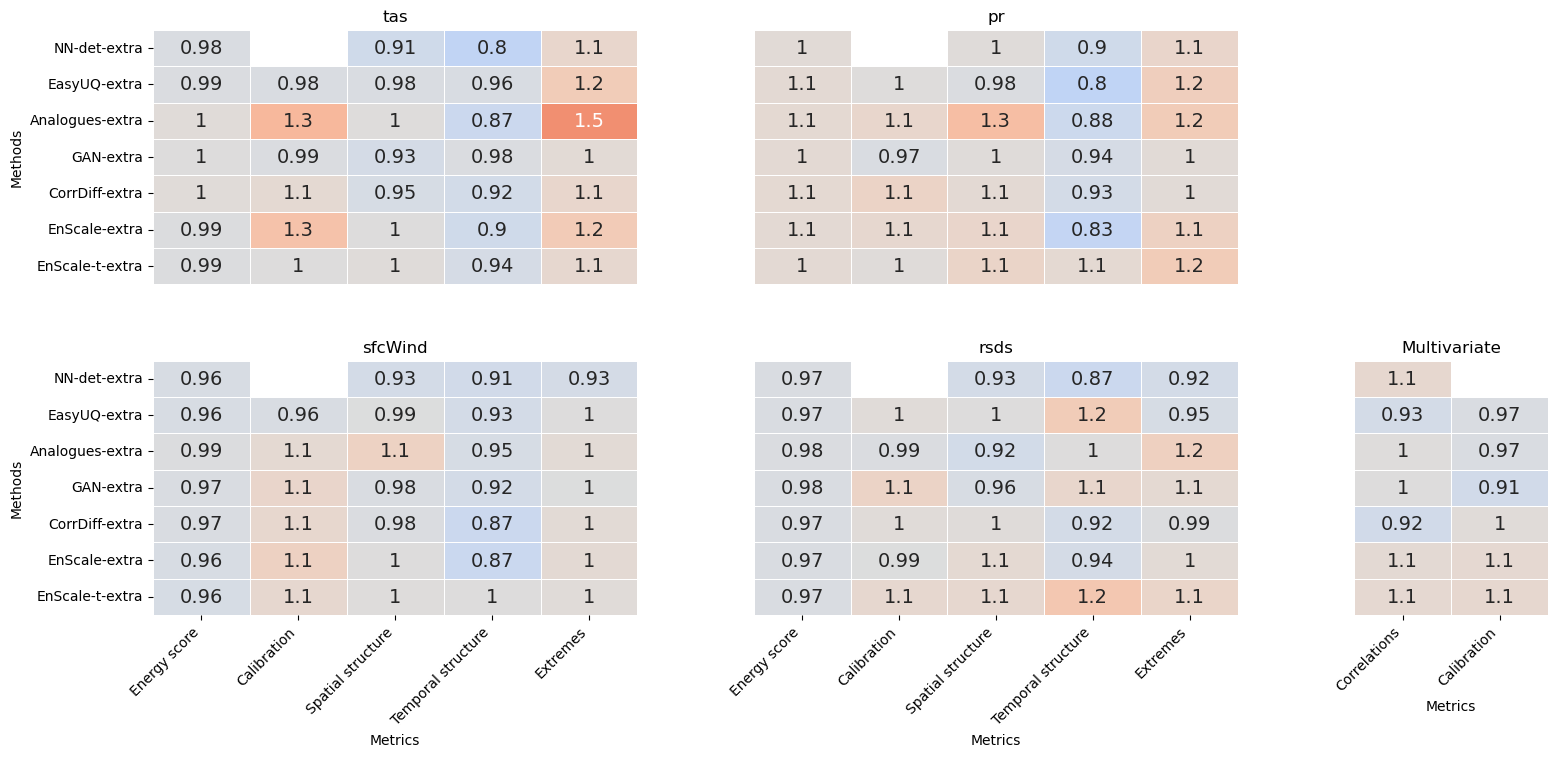

In [88]:
plot_combined_grid(df_ratio_per_var, df_out, metrics_primary, ["Correlations", "Calibration"],
                   method_mapping_extra, method_order_extra, base_method=None, version=version_name + "_ratio_extrapolation")

## CorrDiff vs CorrDiff-s

In [89]:
df_per_var = {}
for var in ['tas', 'pr', 'sfcWind', 'rsds']:
    if folder_name_maybritt is not None:
        df = pd.read_csv(f"output_evals/maybritt/interpolation/{folder_name_maybritt}/{var}/concatenated_results_2030-2039_multiple-methods_2378111217.csv")
    if folder_name_benchmarks is not None:
        df_bench = pd.read_csv(f"output_evals/benchmarks/interpolation/{folder_name_benchmarks}/{var}/concatenated_results_2030-2039_maybritt_3step_dense-conv_v3_2378111217.csv")
    
    if folder_name_maybritt is not None and folder_name_benchmarks is not None:
        df = pd.concat([df, df_bench])
    elif folder_name_benchmarks is not None:
        df = df_bench
    df_per_var[var] = df

In [90]:
if folder_name_maybritt is not None:
    df1 = pd.read_csv(f"output_evals/maybritt/interpolation/{folder_name_maybritt}/multivariate_concatenated_results_2030-2039_multiple-methods_1315.csv")
if folder_name_benchmarks is not None:
    df_bench1 = pd.read_csv(f"output_evals/benchmarks/interpolation/{folder_name_benchmarks}/multivariate_concatenated_results_2030-2039_maybritt_3step_dense-conv_v3_1315.csv")

if folder_name_maybritt is not None and folder_name_benchmarks is not None:
    df_multi = pd.concat([df1, df_bench1])
elif folder_name_benchmarks is not None:
    df_multi = df_bench1

/tmp/ipykernel_1716427/2426392708.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.02, 1, 1])


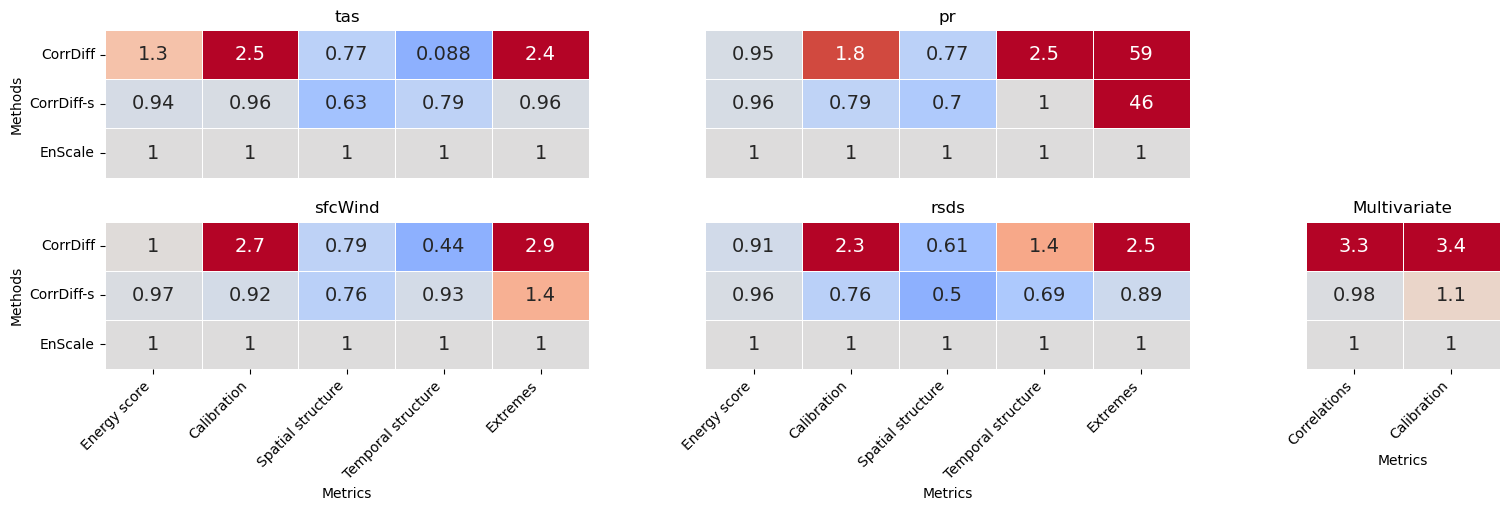

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.gridspec import GridSpec

# ------------------------
# Configuration
# ------------------------

# Original metric list (from your first layout)
metrics_primary = {
    "Energy score": ["mean*ES_pool-None_kernel-1"],
    "Calibration": ["sp_mean_mcb", "sp_max_mcb", "loc_avg_mcb"],
    "Spatial structure": ["mean*CRPS_pool-max_kernel-10", "mean*LSD-daily", "mean*LSD-avg"],
    "Temporal structure": ["ACF_lag1_abs_error_pool-None_kernel-1"],
    "Extremes": ["loc_avg_mcb_last_bin", "loc_avg_mcb_first_bin",
                 "q-error_months-6-7-8_q-0.95", "q-error_months-12-1-2_q-0.05"]
}

# For simple 2x2 overview:
#plot_2x2(df_per_var, metrics_primary, method_mapping, method_order)

method_order_corrdiff = ["CorrDiff", "CorrDiff-s", "EnScale"]

# For combined GridSpec view with multivariate:
df_multivariate_plot = process_multivariate_metrics(
    df_raw=df_multi,
    method_mapping=method_mapping,
    method_order=method_order_corrdiff,
    metric_groups={"Correlations": ["Correlations_pr-sfcWind", "Correlations_sfcWind-rsds", "Correlations_tas-pr"],
                   "Calibration": ["Miscalibration_pr-sfcWind", "Miscalibration_sfcWind-rsds", "Miscalibration_tas-pr"]},  # or your composite structure
    drop_indices=[],
    base_method=base_method,
)

plot_combined_grid(df_per_var, df_multivariate_plot, metrics_primary, ["Correlations", "Calibration"],
                   method_mapping, method_order_corrdiff, base_method=base_method, version=version_name + "_corrdiff-comparison")
